<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Text classification - Naive Bayes
**Dataset**: [Customer reviews](http://www.cse.chalmers.se/~richajo/dit862/data/all_sentiment_shuffled.txt)

**Goals**: Implementing the Naive Bayes classification method and use it for sentiment classification of customer reviews


## Loading data
The original dataset is formatted in .txt, we will reformat and store data into dataframe for our convenience.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Getting data from url
import base64
import requests
re = requests.get ('http://www.cse.chalmers.se/~richajo/dit862/data/all_sentiment_shuffled.txt')
data = re.text

## Data Preprocessing

### Reformatting the Data

In [3]:
# Printing data type and observe the original format of the data
print("data's type:  ", type(data))
print(data[:100])

data's type:   <class 'str'>
music neg 241.txt i bought this album because i loved the title song . it 's such a great song , how


The original data is in the string data type with one review per line. We can split these reviews and reformat into the data dataframe type.

In [4]:
# Reformatting the data

# Separating the data into its four data attributes: reviews, topics, labels, and documment ids
# Creating empty lists of 4 data attributes
reviews, topics, labels, doc_id = [],[],[],[]
# Looping over lines to separate them into reviews, topics, labels, and documment ids
for line in data.splitlines():
  reviews.append(' '.join(token for token in line.split()[3:]))
  topics.append(line.split()[0])
  labels.append(line.split()[1])
  doc_id.append(line.split()[2])

# Storing the separated data into dataframe
df = pd.DataFrame(zip(doc_id, reviews, topics, labels), columns = ['doc_id', 'review', 'topic', 'label'])
print("data's shape: ", df.shape)
df.head()

data's shape:  (11914, 4)


,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,neg
1,544.txt,i was misled and thought i was buying the enti...,music,neg
2,729.txt,"i have introduced many of my ell , high school...",books,neg
3,278.txt,anything you purchase in the left behind serie...,books,pos
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,pos


### Exploring the dependent variable

data distribution in the dependent variable:
 pos    6000
neg    5914
Name: label, dtype: int64


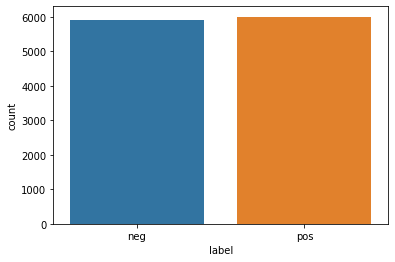

In [5]:
print('data distribution in the dependent variable:\n', df['label'].value_counts())
sns.countplot(data = df, x = 'label')
plt.show()

In [6]:
# Encoding the target labels into the numeric type
df['label'] = np.where(df['label']=='pos', 1, 0)
df.head()

,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,0
1,544.txt,i was misled and thought i was buying the enti...,music,0
2,729.txt,"i have introduced many of my ell , high school...",books,0
3,278.txt,anything you purchase in the left behind serie...,books,1
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,1


### Cleaning data
When doing text classification, data cleaning is an essential part, deciding the model's performance. Some stopwords such as 'the','a', etc. occur most frequently, but contain no useful information. We expect to remove these words from the corpus. We will also remove punctuations. 

In [7]:
# Downloading a stopword list in English
!pip install stop-words
from stop_words import get_stop_words
stop_words = get_stop_words('en')

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=8d150885e4016895f099405955e4a4cef249d8777e516edf38f00b435ce684f5
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [8]:
# Cleaning the reviews
# Removing stopwords, and numerics 
df['review'] = df['review'].apply( lambda x: ' '.join(x for x in str(x).split() if not x.isdigit() and not x.isspace() ) )
df['review'] = df['review'].apply( lambda x: ' '.join(x for x in str(x).split() if x not in stop_words) )
# Removing punctuations and non-letter tokens
df['review']=df['review'].str.replace('[^\w\s]','') # remove punctuations
df['review'].head()

0    bought album loved title song  s great song  b...
1    misled thought buying entire cd contains one song
2    introduced many ell  high school students lois...
3    anything purchase left behind series excellent...
4    loved movies  cant wiat third one  funny  suit...
Name: review, dtype: object

## Developping model

In [9]:
# Representing the review corpus by vector
from sklearn.feature_extraction.text import CountVectorizer
# Creating a vectorizer model that convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(lowercase = False)
# Fitting the vecorizer model to transform words to vectors
features = vectorizer.fit_transform(df['review'])
features_nd = features.toarray()


In [10]:
print(vectorizer.get_feature_names())

['00', '000', '00000', '000feet', '000mb', '000page', '000steps', '004144php', '01', '010', '02071982', '03051983', '039', '04', '04111981', '044', '05', '06', '0611', '07', '074', '08', '0s', '10', '100', '1000', '10000', '100000', '10000i', '1000mg', '1000the', '100120', '100200', '100300', '100300mm', '100400', '100400mm', '100asa', '100g', '100k', '100mm', '100mms', '100pk', '100s', '100th', '101', '10113613', '1012', '10130340345435', '1015', '101mp', '102', '1020', '1020mm', '1022', '1022mm', '10247', '1024x768', '103', '10369711357476654', '1039', '104', '1040a', '1043', '10454599252315938', '1046', '105', '1054', '105mm', '106', '107', '107x', '1080i', '1080n', '1080p', '1099misc', '1099r', '10cc', '10d', '10day', '10latest', '10los', '10m', '10mb', '10meters', '10min', '10mm', '10mp', '10s', '10second', '10step', '10th', '10thgrade', '10x', '10x25', '10x25s', '10x50', '10x50s', '10year', '10yearolds', '10years', '11', '110', '1100', '1100pm', '11021998', '11061992', '110v', '1

In [ ]:
# Splitting the data into training (80%) and test set(20%)

In [12]:
# Creating a naive bayes models for text classification
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()